In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import random

In [2]:
ranks = pd.read_csv('google_cloud_ranks_21.csv')
POM = ranks[ranks.SystemName == 'POM']
POM = POM[POM.RankingDayNum == 133]
POM_21 = POM[POM.Season == 2021]
POM = POM.drop(['RankingDayNum','SystemName'], axis=1)
POM_21 = POM_21.drop(['RankingDayNum','SystemName'], axis=1)
POM.head(5)

,Season,TeamID,OrdinalRank
127259,2003,1102,160
127260,2003,1103,163
127261,2003,1104,33
127262,2003,1105,307
127263,2003,1106,263


## Compile data for 2013-2019 and save as csv

In [3]:
# Load in all data and do some quick cleaning
df = pd.read_csv('kaggle_cbb_2013-19.csv')
df.TEAM = df.TEAM.str.replace(r'[^\w\s]+', '') # get rid of periods in team names
scores = pd.read_csv('google_cloud_compact.csv')
teams = pd.read_csv('google_cloud_teams.csv')

scores = \
    scores \
    .merge(teams[['TeamName', 'TeamID']],
           left_on='WTeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'WTeamName'}) \
    .merge(teams[['TeamName', 'TeamID']],
           left_on='LTeamID',
           right_on='TeamID') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'LTeamName'})
scores = scores[scores.DayNum > 135] # get rid of play-in games
scores = scores.drop(['DayNum','WTeamID','LTeamID','WLoc','NumOT'], axis=1)

scores.head(5)

<ipython-input-3-bef3832a652e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.TEAM = df.TEAM.str.replace(r'[^\w\s]+', '') # get rid of periods in team names


,Season,WScore,LScore,WTeamName,LTeamName
0,1985,63,54,Arkansas,Iowa
1,1997,75,69,Kentucky,Iowa
2,2001,92,79,Kentucky,Iowa
3,1987,84,81,UNLV,Iowa
4,1991,85,70,Duke,Iowa


In [4]:
POM = \
    POM \
    .merge(teams[['TeamName', 'TeamID']],
           left_on='TeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1)

POM.head(5)

,Season,OrdinalRank,TeamName
0,2003,160,Air Force
1,2004,47,Air Force
2,2005,65,Air Force
3,2006,49,Air Force
4,2007,40,Air Force


In [5]:
# Add all the team data for each game
winner_cols = {}
winner_cols['SEED'] = 'W-SEED'
for col in df.columns[2:-3]:
    winner_cols[col] = 'W-' + col

loser_cols = {}
loser_cols['SEED'] = 'L-SEED'
for col in df.columns[2:-3]:
    loser_cols[col] = 'L-' + col

clean = pd.DataFrame()
for yr in np.arange(2013,2019,1):
    
    df_yr = df[df.YEAR == yr]
    scores_yr = scores[scores.Season == yr]
    POM_yr = POM[POM.Season == yr].drop('Season', axis=1)

    scores_yr = scores_yr.merge(df_yr,left_on='WTeamName', right_on='TEAM', how='inner')
    scores_yr = scores_yr.drop(['TEAM','POSTSEASON','YEAR','CONF'], axis=1)
    scores_yr = scores_yr.rename(columns=winner_cols)
    scores_yr = scores_yr.merge(df_yr,left_on='LTeamName', right_on='TEAM', how='inner')
    scores_yr = scores_yr.drop(['TEAM','POSTSEASON','YEAR','CONF'], axis=1)
    scores_yr = scores_yr.rename(columns=loser_cols)
    
    scores_yr = scores_yr.merge(POM_yr,left_on='WTeamName', right_on='TeamName', how='inner')
    scores_yr = scores_yr.drop(['TeamName'], axis=1)
    scores_yr = scores_yr.rename(columns={'OrdinalRank' : 'W-Rank'})
    scores_yr = scores_yr.merge(POM_yr,left_on='LTeamName', right_on='TeamName', how='inner')
    scores_yr = scores_yr.drop(['TeamName'], axis=1)
    scores_yr = scores_yr.rename(columns={'OrdinalRank' : 'L-Rank'})
    
    clean = pd.concat([clean,scores_yr])
    
print('Size of cleaned dataframe: (%d,%d)' %(clean.shape[0], clean.shape[1]))
clean.head(5)

Size of cleaned dataframe: (300,47)


,Season,WScore,LScore,WTeamName,LTeamName,W-G,W-W,W-ADJOE,W-ADJDE,W-BARTHAG,...,L-FTRD,L-2P_O,L-2P_D,L-3P_O,L-3P_D,L-ADJ_T,L-WAB,L-SEED,W-Rank,L-Rank
0,2013,70,58,Kansas,North Carolina,37,31,111.6,86.2,0.9514,...,27.1,46.3,46.3,37.2,34.4,71.4,2.5,8.0,8,28
1,2013,82,76,Louisville,Michigan,40,35,115.9,84.5,0.9743,...,22.7,53.4,47.6,37.9,32.6,64.8,6.2,4.0,2,11
2,2013,85,63,Louisville,Duke,40,35,115.9,84.5,0.9743,...,32.7,50.8,46.2,39.9,29.0,67.8,7.5,2.0,2,6
3,2013,77,69,Louisville,Oregon,40,35,115.9,84.5,0.9743,...,33.3,49.1,44.9,33.3,33.4,69.2,2.9,12.0,2,43
4,2013,72,68,Louisville,Wichita St,40,35,115.9,84.5,0.9743,...,38.3,49.6,43.6,33.9,32.2,65.0,2.2,9.0,2,33


In [6]:
W_cols = {}
for col in clean.columns:
    if col.startswith('W-'):
        W_cols[col] = col.split('-')[1]
    if col.startswith('L-'):
        W_cols[col] = 'Opp_' + col.split('-')[1]

L_cols = {}
for col in clean.columns:
    if col.startswith('L-'):
        L_cols[col] = col.split('-')[1]
    if col.startswith('W-'):
        L_cols[col] = 'Opp_' + col.split('-')[1]
        
W = clean.drop(['Season','WScore','LScore','LTeamName'], axis=1)
W = W.rename(columns={'WTeamName' : 'Team'})
W = W.rename(columns=W_cols)
W['Win'] = 1
L = clean.drop(['Season','WScore','LScore','WTeamName'], axis=1)
L = L.rename(columns={'LTeamName' : 'Team'})
L = L.rename(columns=L_cols)
L['Win'] = 0
new = pd.concat([W,L])
new = new.sample(frac=1).reset_index(drop=True)
new

,Team,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,...,Opp_2P_O,Opp_2P_D,Opp_3P_O,Opp_3P_D,Opp_ADJ_T,Opp_WAB,Opp_SEED,Rank,Opp_Rank,Win
0,Duke,37,29,122.3,92.9,0.9592,55.9,46.4,17.5,17.3,...,46.6,45.1,31.7,31.8,64.0,-0.4,11.0,3,54,1
1,UCLA,36,31,122.8,99.6,0.9175,59.8,48.7,15.1,15.8,...,52.1,41.4,34.5,34.4,65.4,5.6,6.0,18,22,1
2,Purdue,37,30,123.2,95.7,0.9484,57.7,47.0,15.8,17.7,...,51.1,45.1,35.9,32.3,67.6,4.7,3.0,5,12,0
3,Dayton,37,26,113.0,99.1,0.8188,52.4,48.8,18.1,18.8,...,47.7,45.5,33.1,34.5,61.5,7.9,3.0,51,14,1
4,Harvard,29,19,104.9,99.9,0.6362,54.3,49.2,20.8,20.9,...,46.1,42.0,35.1,34.6,65.4,6.9,3.0,108,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Kentucky,39,38,120.3,84.0,0.9842,51.5,39.6,16.3,21.3,...,58.2,47.4,39.0,32.6,63.9,8.6,3.0,1,10,1
596,North Carolina,37,26,120.7,97.1,0.9242,52.0,50.1,16.7,16.3,...,53.2,52.8,32.7,33.8,75.9,-3.2,15.0,7,165,1
597,UNC Asheville,32,20,101.2,99.4,0.5487,49.6,49.3,18.6,22.2,...,57.4,44.1,36.2,33.9,66.7,8.9,2.0,116,5,0
598,Wichita St,33,25,120.9,102.7,0.8671,55.1,49.4,16.5,16.3,...,55.5,48.7,35.9,35.0,75.9,-2.5,13.0,20,114,0


In [7]:
new.to_csv('march_madness.csv')

<AxesSubplot:xlabel='TOR', ylabel='Win'>

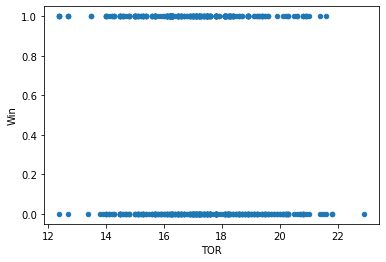

In [8]:
new.plot(x='TOR',y='Win',kind='scatter')

## Create csv file with 2021 data for predictions

In [9]:
# Load in all data and do some quick cleaning
df = pd.read_csv('kaggle_cbb_2021.csv')
df.TEAM = df.TEAM.str.replace(r'[^\w\s]+', '') # get rid of periods in team names
scores = pd.read_csv('google_cloud_compact_21.csv')
teams = pd.read_csv('google_cloud_teams_21.csv')

scores = scores[scores.Season == 2021]

scores = \
    scores \
    .merge(teams[['TeamName', 'TeamID']],
           left_on='WTeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'WTeamName'}) \
    .merge(teams[['TeamName', 'TeamID']],
           left_on='LTeamID',
           right_on='TeamID') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'LTeamName'})
scores = scores[scores.DayNum > 135] # get rid of play-in games
scores = scores.drop(['DayNum','WTeamID','LTeamID','WLoc','NumOT'], axis=1)

df.head(5)

<ipython-input-9-4fbe2ba1bdaa>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.TEAM = df.TEAM.str.replace(r'[^\w\s]+', '') # get rid of periods in team names


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
2,Illinois,B10,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,...,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,8.9,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
4,Iowa,B10,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,...,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,5.6,2.0


In [10]:
POM_21 = \
    POM_21 \
    .merge(teams[['TeamName', 'TeamID']],
           left_on='TeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .drop('Season', axis=1)

POM_21.head(5)

,OrdinalRank,TeamName
0,86,Abilene Chr
1,321,Air Force
2,99,Akron
3,8,Alabama
4,340,Alabama A&M


In [11]:
# Add all the team data for each game
winner_cols = {}
for col in df.columns:
    winner_cols[col] = 'W-' + col

loser_cols = {}
for col in df.columns:
    loser_cols[col] = 'L-' + col

scores = scores.merge(df,left_on='WTeamName', right_on='TEAM', how='inner')
scores = scores.drop(['TEAM','CONF'], axis=1)
scores = scores.rename(columns=winner_cols)
scores = scores.merge(df,left_on='LTeamName', right_on='TEAM', how='inner')
scores = scores.drop(['TEAM','CONF'], axis=1)
scores = scores.rename(columns=loser_cols)

scores = scores.merge(POM_21,left_on='WTeamName', right_on='TeamName', how='inner')
scores = scores.drop(['TeamName'], axis=1)
scores = scores.rename(columns={'OrdinalRank' : 'W-Rank'})
scores = scores.merge(POM_21,left_on='LTeamName', right_on='TeamName', how='inner')
scores = scores.drop(['TeamName'], axis=1)
scores = scores.rename(columns={'OrdinalRank' : 'L-Rank'})

scores.head(5)

,Season,WScore,LScore,WTeamName,LTeamName,W-G,W-W,W-ADJOE,W-ADJDE,W-BARTHAG,...,L-FTRD,L-2P_O,L-2P_D,L-3P_O,L-3P_D,L-ADJ_T,L-WAB,L-SEED,W-Rank,L-Rank
0,2021,53,52,Drake,Wichita St,27,25,111.8,101.6,0.7508,...,29.7,44.7,47.6,34.5,30.8,67.5,1.3,11.0,53,74
1,2021,54,53,Norfolk St,Appalachian St,21,16,99.4,104.1,0.3698,...,24.0,46.7,50.4,32.6,33.5,65.4,-7.7,16.0,197,206
2,2021,86,80,UCLA,Michigan St,26,17,112.3,97.5,0.8350,...,37.1,47.8,48.1,32.0,31.5,68.7,1.4,11.0,44,56
3,2021,73,62,UCLA,BYU,26,17,112.3,97.5,0.8350,...,29.4,54.5,45.5,37.3,32.4,68.2,3.3,6.0,44,24
4,2021,88,78,UCLA,Alabama,26,17,112.3,97.5,0.8350,...,31.9,50.1,46.4,35.1,28.8,73.9,6.8,2.0,44,8


In [12]:
W_cols = {}
for col in scores.columns:
    if col.startswith('W-'):
        W_cols[col] = col.split('-')[1]
    if col.startswith('L-'):
        W_cols[col] = 'Opp_' + col.split('-')[1]

L_cols = {}
for col in scores.columns:
    if col.startswith('L-'):
        L_cols[col] = col.split('-')[1]
    if col.startswith('W-'):
        L_cols[col] = 'Opp_' + col.split('-')[1]
        
W = scores.drop(['Season','WScore','LScore','LTeamName'], axis=1)
W = W.rename(columns={'WTeamName' : 'Team'})
W = W.rename(columns=W_cols)
W['Win'] = 1
L = scores.drop(['Season','WScore','LScore','WTeamName'], axis=1)
L = L.rename(columns={'LTeamName' : 'Team'})
L = L.rename(columns=L_cols)
L['Win'] = 0
new = pd.concat([W,L])
new = new.sample(frac=1).reset_index(drop=True)
new

,Team,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,...,Opp_2P_O,Opp_2P_D,Opp_3P_O,Opp_3P_D,Opp_ADJ_T,Opp_WAB,Opp_SEED,Rank,Opp_Rank,Win
0,Arkansas,28,22,110.4,91.2,0.8997,51.5,47.6,17.4,20.3,...,49.7,49.0,38.8,35.6,71.4,-5.1,15.0,18,151,1
1,Oklahoma,25,15,111.0,94.5,0.8642,50.8,48.9,15.8,18.7,...,52.6,48.3,32.0,32.7,68.6,2.1,9.0,39,51,1
2,Florida,23,14,110.6,93.4,0.8748,52.5,47.5,20.7,20.5,...,51.7,47.6,35.7,33.0,66.5,0.9,10.0,37,50,1
3,North Texas,25,17,104.4,94.6,0.7578,54.0,45.7,20.4,21.4,...,52.8,51.0,35.2,35.4,65.1,3.2,5.0,71,12,0
4,Houston,26,24,120.6,90.9,0.9626,51.3,42.9,16.3,21.6,...,50.9,49.3,33.7,31.6,69.4,0.5,11.0,6,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Missouri,25,16,111.3,95.0,0.8599,50.9,48.5,18.9,18.4,...,50.8,46.3,33.8,35.4,67.6,0.3,8.0,51,39,0
112,Connecticut,22,15,114.6,92.8,0.9188,49.5,46.2,17.6,19.6,...,52.8,46.4,34.9,34.3,65.4,0.2,10.0,16,31,0
113,Texas Tech,27,17,112.3,92.2,0.9057,49.7,47.9,16.2,23.8,...,49.6,42.9,33.6,33.0,69.0,-1.1,11.0,23,40,1
114,Wisconsin,29,17,111.3,90.4,0.9163,49.4,47.9,13.5,17.8,...,54.1,48.1,41.8,34.0,68.8,6.6,1.0,10,4,0


In [13]:
new.to_csv('march_madness_21.csv')